In [60]:
import pandas as pd
df = pd.read_csv("/Users/Taiyaba Surface/Desktop/trans1.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1048575 non-null  int64  
 1   account_id  1048575 non-null  int64  
 2   date        1048575 non-null  int64  
 3   type        1048575 non-null  object 
 4   operation   871046 non-null   object 
 5   amount      1048575 non-null  float64
 6   balance     1048575 non-null  float64
 7   k_symbol    569929 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 64.0+ MB


,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN


In [61]:
# Filling the missing values

df = df.fillna(value='unspecified')

# print unique values of different variables 
[print(df[item].unique()) for item in df if not (item=='trans_id' or item=='balance' or item == 'amount')] 

# print unique, found that some elements of 'k_symbol' is "space", so replace the 'space' with 'unspecified'
df = df.replace(' ', 'unspecified')
df

[2378  576  704 ...  777 3276 1573]
[930101 930102 930103 ... 981217 981218 981219]
['PRIJEM' 'VYDAJ' 'VYBER']
['VKLAD' 'PREVOD Z UCTU' 'VYBER' 'Unspecifed-Operation' 'PREVOD NA UCET'
 'unspecified' 'VYBER KARTOU']
['unspecified' 'DUCHOD' 'UROK' 'SIPO' 'SLUZBY' ' ' 'POJISTNE'
 'SANKC. UROK' 'UVER']


,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,unspecified
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,unspecified
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,unspecified
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,unspecified
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,unspecified
...,...,...,...,...,...,...,...,...
1048570,1106561,3779,981219,VYDAJ,VYBER,12200.0,59783.7,unspecified
1048571,1109169,3787,981219,VYDAJ,VYBER,2600.0,81497.4,unspecified
1048572,1109971,3789,981219,VYBER,VYBER,4900.0,44784.0,unspecified
1048573,1110516,3791,981219,VYDAJ,VYBER,23500.0,60146.1,unspecified


In [3]:
# Remove numeric columns, for simplicity and to compute Categorical intially
df.drop(['trans_id','account_id','date','balance','amount'],axis=1,inplace=True) 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   type       1048575 non-null  object
 1   operation  1048575 non-null  object
 2   k_symbol   1048575 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


,type,operation,k_symbol
0,PRIJEM,VKLAD,unspecified
1,PRIJEM,VKLAD,unspecified
2,PRIJEM,VKLAD,unspecified
3,PRIJEM,VKLAD,unspecified
4,PRIJEM,VKLAD,unspecified


In [4]:
#To compute faster
prepared=df.sample(n=10000, replace=False, random_state=1)  
prepared.shape

(10000, 3)

In [5]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(categories='auto')
OHE.fit(df)
print(OHE.categories_)
prepared=OHE.transform(prepared).toarray()

[array(['PRIJEM', 'VYBER', 'VYDAJ'], dtype=object), array(['PREVOD NA UCET', 'PREVOD Z UCTU', 'Unspecifed-Operation', 'VKLAD',
       'VYBER', 'VYBER KARTOU', 'unspecified'], dtype=object), array(['DUCHOD', 'POJISTNE', 'SANKC. UROK', 'SIPO', 'SLUZBY', 'UROK',
       'UVER', 'unspecified'], dtype=object)]


In [6]:
RowsNumber,InputSize = prepared.shape
print(RowsNumber,InputSize)

10000 18


In [7]:
import numpy as np

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

np.random.seed(42)
tf.random.set_seed(42)

In [8]:
X_train = prepared.astype(np.float32) # TensorFlow expects float32

In [9]:
codings_size = 8  # For InputSize=12

generator = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(InputSize, activation="sigmoid"),
    keras.layers.Reshape([InputSize])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[InputSize]),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [10]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [11]:
batch_size = 20  # For MNIST 60,000 inputs, batch_size was 32

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [12]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        #plot_multiple_images(generated_images, 8)                     # not shown
        #plt.show()  

In [13]:
import time

start = time.time()
train_gan (gan, dataset, batch_size, codings_size, n_epochs=1)
print('TIME ',round(time.time() - start,0))

Epoch 1/1
TIME  7.0


In [14]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[50000*batch_size, codings_size])
generated_ = generator(noise)

In [15]:
generated_[1:3]

<tf.Tensor: shape=(2, 18), dtype=float32, numpy=
array([[2.75976444e-03, 1.99336835e-04, 9.69338655e-01, 8.72382641e-01,
        1.92580111e-02, 2.71673457e-06, 1.79846436e-02, 1.87628716e-01,
        1.47637838e-05, 8.95985228e-04, 4.27033240e-03, 1.20448596e-04,
        4.15632621e-06, 7.03084022e-02, 1.94654882e-01, 2.37267721e-03,
        7.91705024e-05, 8.50648463e-01],
       [4.35017794e-01, 5.16969594e-05, 9.54331279e-01, 1.13218706e-02,
        8.54421314e-03, 5.15844533e-07, 3.76135902e-03, 9.79575217e-01,
        2.61246873e-06, 2.53898348e-03, 5.30983740e-03, 1.33604690e-05,
        6.85943107e-08, 3.84895422e-04, 2.09065387e-04, 3.94319184e-02,
        1.81708867e-06, 9.98625398e-01]], dtype=float32)>

In [16]:
print(type(np.array(generated_)))

<class 'numpy.ndarray'>


In [17]:
x = (np.array(generated_))

type(x)

numpy.ndarray

In [18]:
gen_df = pd.DataFrame(x)

type(gen_df)

pandas.core.frame.DataFrame

In [19]:
gen_df[1:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1,0.002760,0.000199,0.969339,0.872383,0.019258,2.716735e-06,0.017985,0.187629,0.000015,0.000896,0.004270,0.000120,4.156326e-06,0.070308,0.194655,0.002373,0.000079,0.850648
2,0.435018,0.000052,0.954331,0.011322,0.008544,5.158445e-07,0.003761,0.979575,0.000003,0.002539,0.005310,0.000013,6.859431e-08,0.000385,0.000209,0.039432,0.000002,0.998625
3,0.195516,0.000065,0.948649,0.175937,0.012674,1.701784e-06,0.020698,0.755822,0.000005,0.003017,0.010151,0.000053,1.009823e-06,0.001754,0.005227,0.018814,0.000008,0.989622
4,0.140496,0.000034,0.954600,0.023363,0.023649,5.333604e-07,0.003256,0.893985,0.000002,0.001075,0.002278,0.000003,2.438903e-07,0.014675,0.007084,0.007361,0.000004,0.863440
5,0.185222,0.000830,0.897766,0.587165,0.044887,8.474838e-05,0.373616,0.190405,0.000122,0.013522,0.042501,0.000792,7.117853e-05,0.071727,0.236050,0.024244,0.000149,0.556907
6,0.096902,0.000225,0.941430,0.182307,0.040433,6.070815e-06,0.041881,0.489609,0.000017,0.002782,0.006198,0.000034,4.265828e-06,0.102244,0.146839,0.005733,0.000043,0.308328
7,0.494165,0.000119,0.914706,0.088326,0.030773,5.311703e-06,0.046870,0.815065,0.000011,0.005071,0.016218,0.000055,3.292091e-06,0.002689,0.007194,0.025639,0.000020,0.983704
8,0.000378,0.000079,0.978701,0.693835,0.018956,1.662223e-06,0.001490,0.369452,0.000018,0.000414,0.001585,0.000040,2.375582e-06,0.090757,0.157844,0.006858,0.000093,0.827885
9,0.018652,0.000118,0.962566,0.617877,0.022810,3.807563e-06,0.044318,0.262000,0.000013,0.001587,0.006341,0.000093,3.390858e-06,0.040914,0.134573,0.004484,0.000043,0.786536


In [20]:
# From the above cell, it clear that 0,1,2 columns corresponds to type
# 3,4,5,6,7,8 column corresponds to operation 
# 9,10,11,12,13,14,15,16 columns corresponds to k_symbol
# Grouping the columns to produce a single column for - Type, Operation and Symbol

# print length of unique number of each columns 
[print(x,len(df[x].unique())) for x in df]

type 3
operation 7
k_symbol 8


[None, None, None]

In [21]:
# From columns 0,1,2 -> getting the largest value column as a new column known as 'type' 
# Largest column Method to group the columns (from https://medium.com/@dkhundley/data-science-quick-tips-001-reversing-one-hot-encoding-b0c9a892356b)

Type = gen_df.iloc[:,0:3]
Type['Type'] = Type.idxmax(axis = 1)


Type.tail()
# 0 -> PRIJEM
# 1 -> VJDAY
# 2 -> VYBER

C:\Users\Taiyaba Surface\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,0,1,2,Type
999995,0.263706,0.000031,0.958142,2
999996,0.220322,0.005697,0.842339,2
999997,0.239427,0.000414,0.922745,2
999998,0.297143,0.000251,0.920798,2
999999,0.021087,0.000007,0.976830,2


In [22]:
# From columns 3,4,5,6,7,8 -> getting the largest value column as a new column known as 'Operation' 

Operation = gen_df.iloc[:,3:9]
Operation['Operation'] = Operation.idxmax(axis = 1)

Operation.head()

C:\Users\Taiyaba Surface\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,3,4,5,6,7,8,Operation
0,0.704103,0.079331,8.688265e-05,0.068719,0.186084,0.000258,3
1,0.872383,0.019258,2.716735e-06,0.017985,0.187629,0.000015,3
2,0.011322,0.008544,5.158445e-07,0.003761,0.979575,0.000003,7
3,0.175937,0.012674,1.701784e-06,0.020698,0.755822,0.000005,7
4,0.023363,0.023649,5.333604e-07,0.003256,0.893985,0.000002,7


In [23]:
# From columns 9,10,11,12,13,14,15,16 -> getting the largest value column as a new column known as 'k_symbol' 

K_symbol = gen_df.iloc[:,9:17]
K_symbol['K_symbol'] = K_symbol.idxmax(axis = 1)

K_symbol.head()

C:\Users\Taiyaba Surface\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,9,10,11,12,13,14,15,16,K_symbol
0,0.005133,0.008392,0.000298,7.546199e-05,0.770726,0.747679,0.007285,0.000802,13
1,0.000896,0.004270,0.000120,4.156326e-06,0.070308,0.194655,0.002373,0.000079,14
2,0.002539,0.005310,0.000013,6.859431e-08,0.000385,0.000209,0.039432,0.000002,15
3,0.003017,0.010151,0.000053,1.009823e-06,0.001754,0.005227,0.018814,0.000008,15
4,0.001075,0.002278,0.000003,2.438903e-07,0.014675,0.007084,0.007361,0.000004,13


In [24]:
# Creating a new dataframe to display the generated data
generated_cat = pd.DataFrame(Type['Type'])
generated_cat['operation'] = Operation['Operation']
generated_cat['k_symbol'] = K_symbol['K_symbol']

In [25]:
generated_cat.head()

# we are displaying the largest column of all the three (meaning )

# Type - 0 means PRIJEM
# (meaning) PRIJEM | VJDAY | VYBER      
#             1       0       0      #one-hot

# Type - 1 means VJDAY
# (meaning) PRIJEM | VJDAY | VYBER 
#             0        1      0

# Type - 2 means VYBER
# (meaning) PRIJEM | VJDAY |VYBER
#              0       0      1

,Type,operation,k_symbol
0,2,3,13
1,2,3,14
2,2,7,15
3,2,7,15
4,2,7,13


In [26]:
# Operation - 3 means PREVOD NA UCET
# (meaning) PREVOD NA UCET | PREVOD Z UCTU | VKLAD | VYBER | VYBER KARTOU | Unspecified
#                 1               0            0       0          0            0

# Operation - 4 means PREVOD Z UCTU
# (meaning) PREVOD NA UCET | PREVOD Z UCTU | VKLAD | VYBER | VYBER KARTOU | Unspecified
#                 0              1            0       0          0            0

# Operation - 5 means VKLAD
# (meaning) PREVOD NA UCET | PREVOD Z UCTU | VKLAD | VYBER | VYBER KARTOU | Unspecified
#                 0               0            1       0          0            0

# Operation - 6 means VYBER
# (meaning) PREVOD NA UCET | PREVOD Z UCTU | VKLAD | VYBER | VYBER KARTOU | Unspecified
#                                0            0       1          0            0

# Operation - 7 means VYBER KARTOU
# (meaning) PREVOD NA UCET | PREVOD Z UCTU | VKLAD | VYBER | VYBER KARTOU | Unspecified
#                 0               0            0       0          1            0

# Operation - 8 means Unspecified
# (meaning) PREVOD NA UCET | PREVOD Z UCTU | VKLAD | VYBER | VYBER KARTOU | Unspecified
#                 0              0            0       0          0            1

# Same logic for K_symbol

In [27]:
generated_cat.tail()

,Type,operation,k_symbol
999995,2,7,15
999996,2,6,14
999997,2,7,14
999998,2,7,13
999999,2,7,15


In [28]:
# Converting the generated data back to original dataset

generated_cat['Type']=generated_cat['Type'].replace({0:'PRIJEM',1:'VYDAJ',2:'VYBER'})
generated_cat['operation']=generated_cat['operation'].replace({3:'PREVOD NA UCET',4:'PREVOD Z UCTU',5:'VKLAD',6:'VYBER',7:'VYBER KARTOU',8:'Unspecified'})
generated_cat['k_symbol']=generated_cat['k_symbol'].replace({9:'DUCHOD',10:'POJISTNE',11:'SANKC.UROK',12:'SIPO',13:'SLUZBY',14:'UROK',15:'UVER',16:'Unspecified'})

In [29]:
generated_cat.tail()

,Type,operation,k_symbol
999995,VYBER,VYBER KARTOU,UVER
999996,VYBER,VYBER,UROK
999997,VYBER,VYBER KARTOU,UROK
999998,VYBER,VYBER KARTOU,SLUZBY
999999,VYBER,VYBER KARTOU,UVER


In [30]:
import pandas as pd
df1 = pd.read_csv("/Users/Taiyaba Surface/Desktop/trans1.csv")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1048575 non-null  int64  
 1   account_id  1048575 non-null  int64  
 2   date        1048575 non-null  int64  
 3   type        1048575 non-null  object 
 4   operation   871046 non-null   object 
 5   amount      1048575 non-null  float64
 6   balance     1048575 non-null  float64
 7   k_symbol    569929 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 64.0+ MB


In [31]:
# Remove numeric columns, for simplicity and to compute numerical columns 
df1.drop(['trans_id','account_id','date','type','k_symbol','operation'],axis=1,inplace=True) 
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   amount   1048575 non-null  float64
 1   balance  1048575 non-null  float64
dtypes: float64(2)
memory usage: 16.0 MB


,amount,balance
0,700.0,700.0
1,900.0,900.0
2,1000.0,1000.0
3,600.0,600.0
4,400.0,400.0


In [32]:
# To compute faster
df1=df1.sample(n=1000, replace=False, random_state=1)  
df1.shape

(1000, 2)

In [33]:
prepared=df1.to_numpy()

In [34]:
RowsNumber,InputSize = prepared.shape
print(RowsNumber,InputSize)

1000 2


In [35]:
import numpy as np

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

np.random.seed(42)
tf.random.set_seed(42) #ensure to get the same results on the machine

In [36]:
X_train = prepared.astype(np.float32) # TensorFlow expects float32

In [37]:
codings_size = 8 # For InputSize=12

generator = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(InputSize, activation="sigmoid"),
    keras.layers.Reshape([InputSize])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[InputSize]),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [38]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [39]:
batch_size = 20  # For MNIST 60,000 inputs, batch_size was 32


dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [40]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        #plot_multiple_images(generated_images, 8)                     # not shown
        #plt.show()                                                    # not shown

In [41]:
import time

start = time.time()
train_gan (gan, dataset, batch_size, codings_size, n_epochs=1)
print('TIME ',round(time.time() - start,0))

Epoch 1/1
TIME  1.0


In [42]:
tf.random.set_seed(42)
np.random.seed(42)                                                           

noise = tf.random.normal(shape=[50000*batch_size, codings_size])
generated_ = generator(noise)

In [43]:
generated_[1:5]                                                      #Synthetic Data generated 

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.21533868, 0.09475406],
       [0.10513775, 0.16129498],
       [0.16107504, 0.08873447],
       [0.13950764, 0.45503   ]], dtype=float32)>

In [44]:
print(type(np.array(generated_)))

<class 'numpy.ndarray'>


In [45]:
x = (np.array(generated_))                                  
type(x)

numpy.ndarray

In [46]:
gen_df = pd.DataFrame(x)                                        #Synthetic Dataframe generated 
type(gen_df)

pandas.core.frame.DataFrame

In [47]:
gen_df[1:5]                                                    

# Output doesn't look like the amount and balance in the original data

,0,1
1,0.215339,0.094754
2,0.105138,0.161295
3,0.161075,0.088734
4,0.139508,0.455030


In [48]:
# Using ryan's method to get the amount and balance values (resembling the original values)
amount_std = df1['amount'].std()
amount_mean = df1['amount'].mean()

In [49]:
# when reversed, the amount should resemble the original_amount (Method: using the mean and std)
amount = gen_df.iloc[:,1] * (amount_std + amount_mean)
amount.head()

0    2255.431885
1    1553.019409
2    2643.625488
3    1454.358276
4    7457.943359
Name: 1, dtype: float32

In [50]:
type(amount)

pandas.core.series.Series

In [51]:
balance_std = df1['balance'].std()
balance_mean = df1['balance'].mean()

In [52]:
balance = gen_df.iloc[:,-1] * (balance_std + balance_mean)
balance.head()

0     8511.186523
1     5860.535645
2     9976.088867
3     5488.223633
4    28143.589844
Name: 1, dtype: float32

In [53]:
# Creating new dataframe with amount and balance

column_names = ["amount", "balance"]
new_data = pd.DataFrame(columns = column_names)

new_data['balance'] = balance
new_data['amount'] = amount
new_data.head()

,amount,balance
0,2255.431885,8511.186523
1,1553.019409,5860.535645
2,2643.625488,9976.088867
3,1454.358276,5488.223633
4,7457.943359,28143.589844


In [54]:
# Rounding-off the values of amount and balance

new_data['amount'] = new_data['amount'].apply(np.floor)
new_data['balance'] = new_data['balance'].apply(np.floor)
new_data.head()

,amount,balance
0,2255.0,8511.0
1,1553.0,5860.0
2,2643.0,9976.0
3,1454.0,5488.0
4,7457.0,28143.0


In [55]:
# Combining the categorical variable - synthetic output with the numerical variable - synthetic output

generated_data = pd.DataFrame(generated_cat, columns=['Type','operation','k_symbol'])

In [56]:
generated_data['balance'] = new_data['balance']
generated_data['amount'] = new_data['amount']

In [57]:
generated_data.head() #1 Million rows

# Trans_id and Account_id -> generate random numbers between its min and max range
# Date --> still figuring out (it didn't resemble the original values and difficult to explain the output)

,Type,operation,k_symbol,balance,amount
0,VYBER,PREVOD NA UCET,SLUZBY,8511.0,2255.0
1,VYBER,PREVOD NA UCET,UROK,5860.0,1553.0
2,VYBER,VYBER KARTOU,UVER,9976.0,2643.0
3,VYBER,VYBER KARTOU,UVER,5488.0,1454.0
4,VYBER,VYBER KARTOU,SLUZBY,28143.0,7457.0


In [58]:
generated_data.info() #1 Million rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Type       1000000 non-null  object 
 1   operation  1000000 non-null  object 
 2   k_symbol   1000000 non-null  object 
 3   balance    1000000 non-null  float32
 4   amount     1000000 non-null  float32
dtypes: float32(2), object(3)
memory usage: 30.5+ MB


In [59]:
from scipy.stats import entropy

In [62]:
df                                                          #Ran first two cells again to get original data

,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,unspecified
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,unspecified
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,unspecified
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,unspecified
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,unspecified
...,...,...,...,...,...,...,...,...
1048570,1106561,3779,981219,VYDAJ,VYBER,12200.0,59783.7,unspecified
1048571,1109169,3787,981219,VYDAJ,VYBER,2600.0,81497.4,unspecified
1048572,1109971,3789,981219,VYBER,VYBER,4900.0,44784.0,unspecified
1048573,1110516,3791,981219,VYDAJ,VYBER,23500.0,60146.1,unspecified


In [63]:
df.drop(['trans_id','account_id', 'date'],axis=1,inplace=True)
df

,type,operation,amount,balance,k_symbol
0,PRIJEM,VKLAD,700.0,700.0,unspecified
1,PRIJEM,VKLAD,900.0,900.0,unspecified
2,PRIJEM,VKLAD,1000.0,1000.0,unspecified
3,PRIJEM,VKLAD,600.0,600.0,unspecified
4,PRIJEM,VKLAD,400.0,400.0,unspecified
...,...,...,...,...,...
1048570,VYDAJ,VYBER,12200.0,59783.7,unspecified
1048571,VYDAJ,VYBER,2600.0,81497.4,unspecified
1048572,VYBER,VYBER,4900.0,44784.0,unspecified
1048573,VYDAJ,VYBER,23500.0,60146.1,unspecified


In [64]:
generated_data

,Type,operation,k_symbol,balance,amount
0,VYBER,PREVOD NA UCET,SLUZBY,8511.0,2255.0
1,VYBER,PREVOD NA UCET,UROK,5860.0,1553.0
2,VYBER,VYBER KARTOU,UVER,9976.0,2643.0
3,VYBER,VYBER KARTOU,UVER,5488.0,1454.0
4,VYBER,VYBER KARTOU,SLUZBY,28143.0,7457.0
...,...,...,...,...,...
999995,VYBER,VYBER KARTOU,UVER,13931.0,3691.0
999996,VYBER,VYBER,UROK,23839.0,6317.0
999997,VYBER,VYBER KARTOU,UROK,25706.0,6812.0
999998,VYBER,VYBER KARTOU,SLUZBY,41000.0,10865.0


In [65]:
new_data = df.sample(n=1000000, replace=False, random_state=1)    #Both datasets have same shape
new_data.shape                                                    #new_data is original dataset with 1M row shape

(1000000, 5)

In [66]:
new_data['type'].value_counts(ascending = True)                 #Finding number of distinct values and total values

VYBER      15724
PRIJEM    381590
VYDAJ     602686
Name: type, dtype: int64

In [67]:
generated_data['Type'].value_counts(ascending = True)

VYDAJ        126
PRIJEM     65553
VYBER     934321
Name: Type, dtype: int64

P=1.000 Q=1.000


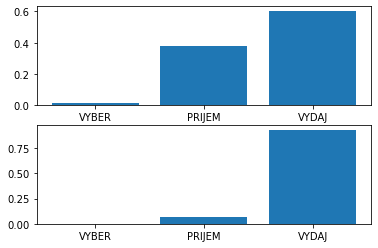

In [68]:
from matplotlib import pyplot
type = ['VYBER', 'PRIJEM', 'VYDAJ']
p = [0.015724, 0.381590, 0.602686]
q = [0.000126, 0.065553, 0.934321]
print('P=%.3f Q=%.3f' % (sum(p), sum(q)))
# plot first distribution
pyplot.subplot(2,1,1)
pyplot.bar(type, p)
# plot second distribution
pyplot.subplot(2,1,2)
pyplot.bar(type, q)
# show the plot
pyplot.show()

In [69]:
from math import log2
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))


In [70]:
# calculate (P || Q)
kl_pq = kl_divergence(p, q) 
print(kl_pq)

0.6980172597980372


In [71]:
# Calculate (Q // P) reverse
kl_qp = kl_divergence(q, p)
print(kl_qp)

0.4235024544637879


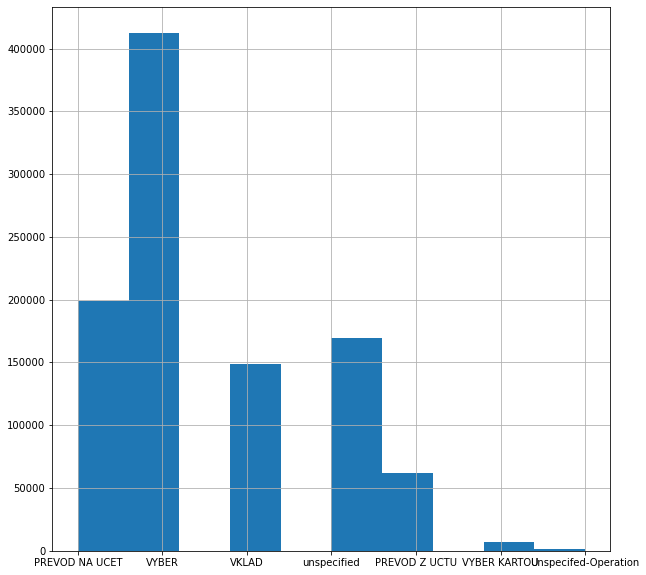

In [72]:
new_data['operation'].hist(figsize=(10,10))

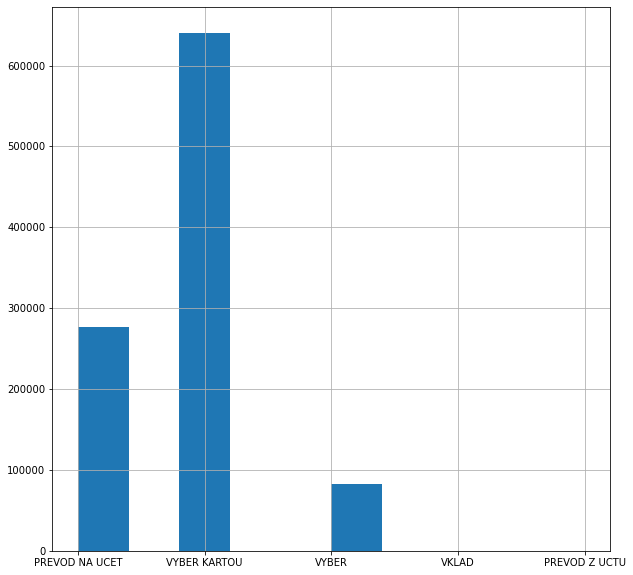

In [73]:
generated_data['operation'].hist(figsize=(10,10))

In [74]:
new_data['operation'].value_counts(ascending = True)                 #unequal shape due to outliers

Unspecifed-Operation      1135
VYBER KARTOU              7296
PREVOD Z UCTU            62213
VKLAD                   149036
unspecified             169258
PREVOD NA UCET          198696
VYBER                   412366
Name: operation, dtype: int64

In [75]:
generated_data['operation'].value_counts(ascending = True) #Limitation of taking five highest values and converting them as part of decoding one hot encoding method

PREVOD Z UCTU          1
VKLAD                  3
VYBER              83022
PREVOD NA UCET    276738
VYBER KARTOU      640236
Name: operation, dtype: int64

P=1.000 Q=1.000


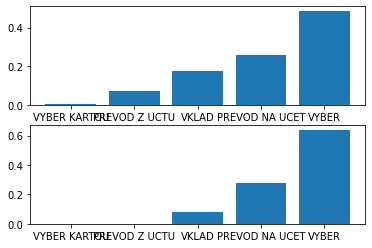

In [76]:
from matplotlib import pyplot
operation = ['VYBER KARTOU', 'PREVOD Z UCTU', 'VKLAD','PREVOD NA UCET','VYBER']    #not including outliers (unspecified operation and operation)
p = [0.008, 0.074, 0.175, 0.258, 0.485]  #Only taking proportion of 5 distinct values instead of 7 due to GANs generation of different data
q = [0.000001, 0.000003, 0.083022, 0.276738, 0.640236]   
print('P=%.3f Q=%.3f' % (sum(p), sum(q)))
# plot first distribution
pyplot.subplot(2,1,1)
pyplot.bar(operation, p)
# plot second distribution
pyplot.subplot(2,1,2)
pyplot.bar(operation, q)
# show the plot
pyplot.show()

In [77]:
from math import log2
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

In [78]:
# calculate (P || Q)
kl_pq = kl_divergence(p, q) 
print(kl_pq)

1.1512729060530296


In [79]:
# Calculate (Q // P)
kl_qp = kl_divergence(q, p)
print(kl_qp)

0.1951117860478755


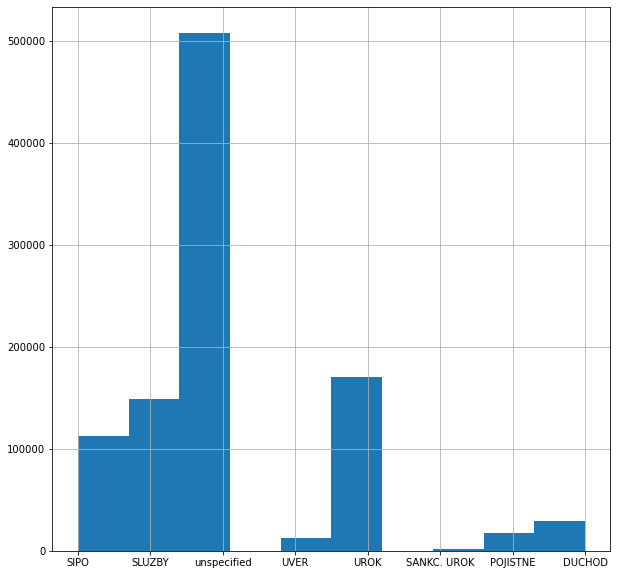

In [80]:
new_data['k_symbol'].hist(figsize=(10,10))

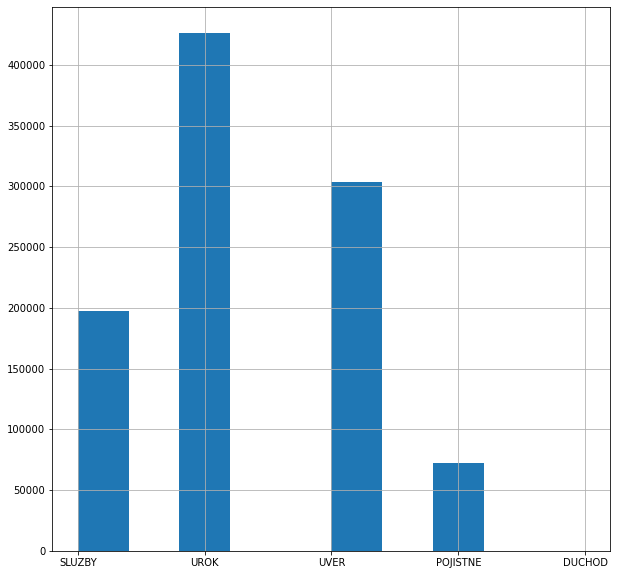

In [81]:
generated_data['k_symbol'].hist(figsize=(10,10))

In [82]:
new_data['k_symbol'].value_counts(ascending = True)

SANKC. UROK      1466
UVER            12910
POJISTNE        17625
DUCHOD          29006
SIPO           112627
SLUZBY         148748
UROK           170330
unspecified    507288
Name: k_symbol, dtype: int64

In [83]:
generated_data['k_symbol'].value_counts(ascending = True)        #3 distinct values missing from original 

DUCHOD         219
POJISTNE     72406
SLUZBY      197595
UVER        303562
UROK        426218
Name: k_symbol, dtype: int64

P=1.000 Q=1.000


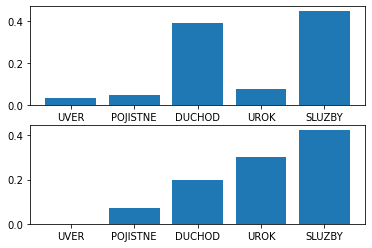

In [84]:
from matplotlib import pyplot
k_symbol = ['UVER', 'POJISTNE', 'DUCHOD', 'UROK', 'SLUZBY']                     
p = [0.0341, 0.0466, 0.393, 0.077, 0.4493]                  #Only comparing 5 distinct values generated in synthetic data
q = [0.000219, 0.072406, 0.197595, 0.303562, 0.426218]      #Formula does not work without category matching 
                                              #Limitation of taking five highest values and converting them as part of decoding one hot encoding methodprint('P=%.3f Q=%.3f' % (sum(p), sum(q)))
# plot first distribution (original data)
pyplot.subplot(2,1,1)
pyplot.bar(k_symbol, p)
# plot second distribution (synthetic data)
pyplot.subplot(2,1,2)
pyplot.bar(k_symbol, q)
# show the plot
pyplot.show()

In [85]:
from math import log2
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

In [86]:
# calculate (P || Q)
kl_pq = kl_divergence(p, q) 
print(kl_pq)

0.4903603687445523


In [87]:
# Calculate (Q // P)
kl_qp = kl_divergence(q, p)
print(kl_qp)

0.41676626168375147


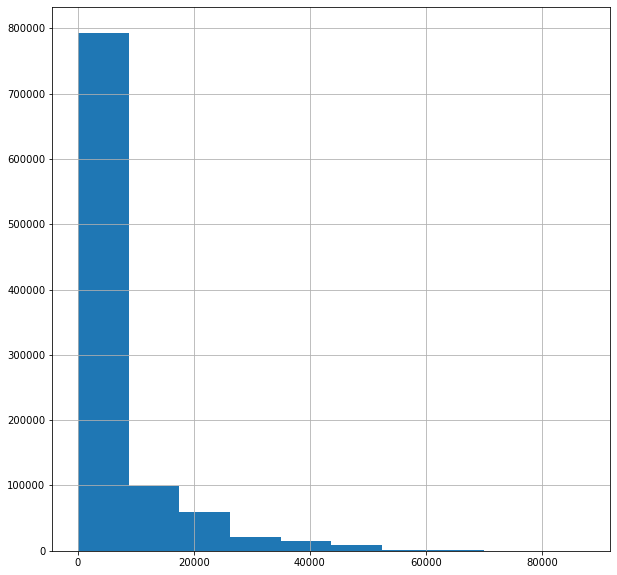

In [88]:
new_data['amount'].hist(figsize=(10,10))                                      

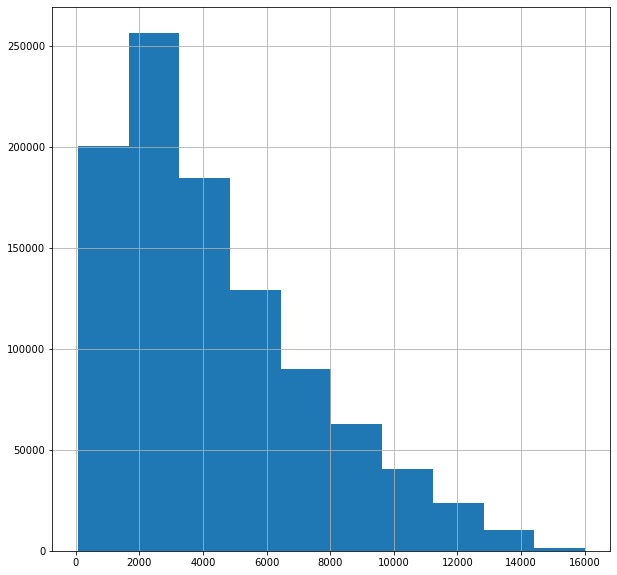

In [89]:
generated_data['amount'].hist(figsize=(10,10))             #Uneven range from synthetic data generated

In [100]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot

In [101]:
import numpy as np
new_data = new_data['amount'].values.reshape(-1, 1)
generated_data = generated_data['amount'].values.reshape(-1, 1)       #Error generated after restarting the kernal?

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [102]:
trans = MinMaxScaler()
data0 = trans.fit_transform(new_data)                          #Rescaled 'amount' column to have equal ranges
data1 = trans.fit_transform(generated_data)

In [103]:
dataset0 = pd.DataFrame(data0)
dataset1 = pd.DataFrame(data1)

In [104]:
print(dataset0.describe())                                         #Original Data Rescaled statistics
print(dataset1.describe())                                         #Synthetic Data Rescaled statistics

                    0
count  1000000.000000
mean         0.317314
std          0.087994
min          0.000000
25%          0.253250
50%          0.295939
75%          0.361376
max          1.000000
                    0
count  1000000.000000
mean         0.269614
std          0.191995
min          0.000000
25%          0.117584
50%          0.220392
75%          0.381303
max          1.000000


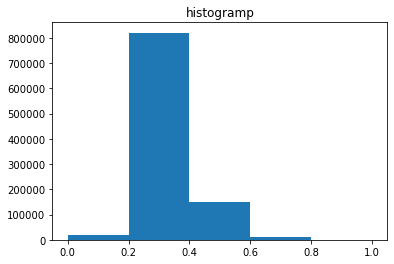

In [142]:
from matplotlib import pyplot as plt       #Original Amount Column Histogram with common range in order to compare
import numpy as np   
   
a = np.array(dataset0) 
plt.hist(a, bins = [0, 0.2, 0.4, 0.6, 0.8, 1]) 
plt.title("histogramp") 
plt.show()  #Probability Distribution counted by proportion of data points in each bin in proportion to total

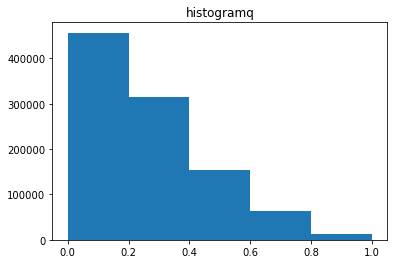

In [141]:
from matplotlib import pyplot as plt    #Synthetic Amount Column Histogram with common range in order to compare
import numpy as np  
   
a = np.array(dataset1) 
plt.hist(a, bins = [0, 0.2, 0.4, 0.6, 0.8, 1]) 
plt.title("histogramq") 
plt.show()  #Probability Distribution counted by proportion of data points in each bin in proportion to total

In [133]:
p = [0.01, 0.15, 0.01, 0.83]
q = [0.59, 0.30 , 0.15, 0.05, 0.01]

In [134]:
from math import log2
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

In [135]:
# calculate (P || Q)
kl_pq = kl_divergence(p, q) 
print(kl_pq)                                                 

3.1161870728117327


In [136]:
# Calculate (Q // P)
kl_qp = kl_divergence(q, p)
print(kl_qp)                                        #Cannot calulate reverse, possibly due to being numerical column? 

IndexError: list index out of range

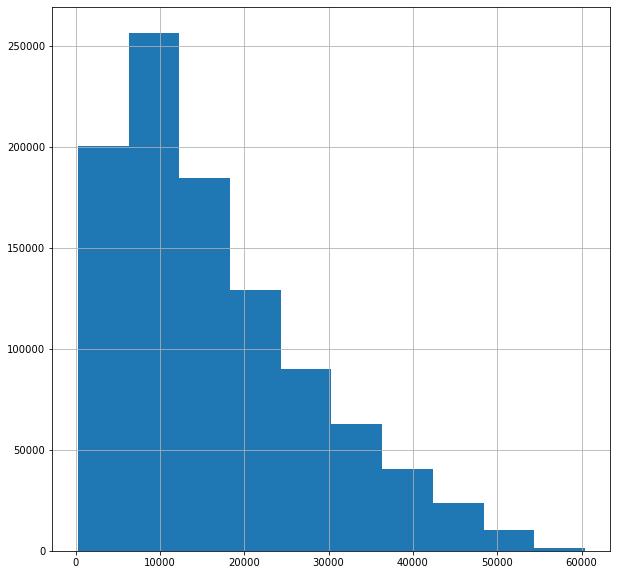

In [90]:
generated_data['balance'].hist(figsize=(10,10))                 #Synthetic Balance Column     

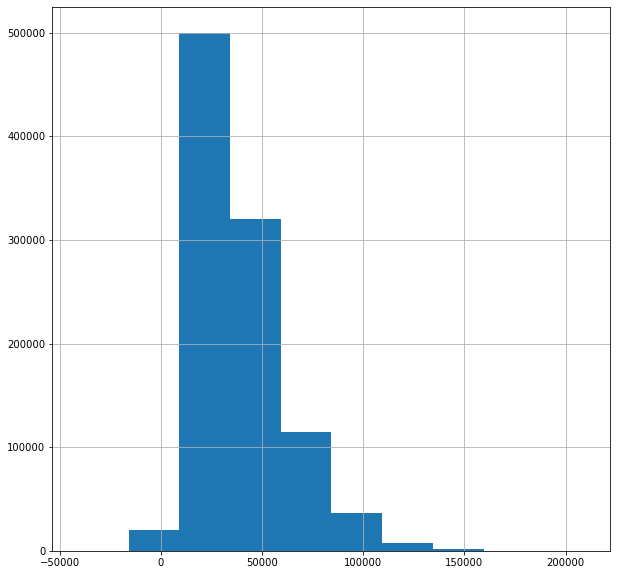

In [91]:
new_data['balance'].hist(figsize=(10,10))                   #Original Balance Column with different range vs synthetic

In [92]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot

In [93]:
import numpy as np
new_data = new_data['balance'].values.reshape(-1, 1)
generated_data = generated_data['balance'].values.reshape(-1, 1)   #Reshaped as some data points are negative and range is different

In [94]:
trans = MinMaxScaler()
data2 = trans.fit_transform(new_data)
data3 = trans.fit_transform(generated_data)

In [96]:
dataset2 = pd.DataFrame(data2) 
dataset3 = pd.DataFrame(data3)                             

In [97]:
print(dataset2.describe())                                      #Original Data Rescaled statistics   
print(dataset3.describe())                                      #Synthetic Data Rescaled statistics

                    0
count  1000000.000000
mean         0.317314
std          0.087994
min          0.000000
25%          0.253250
50%          0.295939
75%          0.361376
max          1.000000
                    0
count  1000000.000000
mean         0.269614
std          0.191995
min          0.000000
25%          0.117584
50%          0.220392
75%          0.381303
max          1.000000


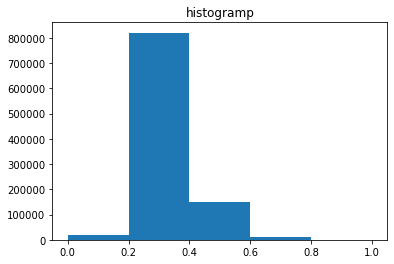

In [140]:
from matplotlib import pyplot as plt ##Probability Distribution counted by proportion of data points in each bin in proportion to total
import numpy as np                           #Similar histogram is generated as Amount Column
   
a = np.array(dataset2) 
plt.hist(a, bins = [0, 0.2, 0.4, 0.6, 0.8, 1]) 
plt.title("histogramp") 
plt.show()

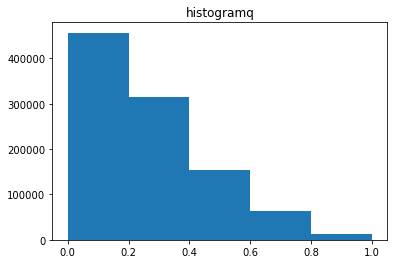

In [139]:
from matplotlib import pyplot as plt            
                                                #Similar histogram is generated as Amount Column
import numpy as np  
   
a = np.array(dataset3) 
plt.hist(a, bins = [0, 0.2, 0.4, 0.6, 0.8, 1]) 
plt.title("histogramq") 
plt.show()               #Probability Distribution counted by proportion of data points in each bin in proportion to total

In [127]:
p = [0.01, 0.15, 0.01, 0.83]                           
q = [0.59, 0.30 , 0.15, 0.05, 0.01]   

In [128]:
from math import log2
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

In [129]:
# calculate (P || Q)
kl_pq = kl_divergence(p, q)  
print(kl_pq)

3.1161870728117327
